In [1]:
import torch
from squeeze_pose_net import SqueezePoseNetDecoder, SqueezePoseNetEncoder
from decoder import ConvDecoder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from torch import nn
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

In [2]:
with open("/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/data/outside_rot_mono8_1_10k_norm_np.pkl", 'rb') as f:
    data = pickle.load(f)

pose, img = data

In [3]:
# data preperation
batch_size = 100
train_test_ratio = 0.7

ratio_id = int(pose.shape[0] * train_test_ratio)

train_pose = pose[:ratio_id]
train_img = img[:ratio_id]
test_pose = pose[ratio_id:]
test_img = img[ratio_id:]

train_set = TensorDataset(torch.from_numpy(train_pose).float(), torch.from_numpy(train_img).float())
test_set = TensorDataset(torch.from_numpy(test_pose).float(), torch.from_numpy(test_img).float())

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
print('Device: ', device)

epochs = 200

net = ConvDecoder()

net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.95)
criterion = nn.MSELoss()

train_loss_epoch = []
train_loss_total = []

test_loss_epoch = []
test_loss_total = []

for epoch in range(epochs):
    net.train()
    train_loss_batch = []
    for i, (pose, img) in enumerate(train_loader):
        pose = pose.unsqueeze(1).to(device)
        img = img.unsqueeze(1).to(device)

        optimizer.zero_grad()  # zero the gradient buffers
        output = net(pose)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()  # Does the update
        loss = loss.item()

        train_loss_batch.append(loss)
        train_loss_total.append(loss)

    scheduler.step()

    train_loss_epoch.append(np.mean(train_loss_batch))
    
    if epoch%1==0:
        net.eval()
        test_loss_batch = []
        for i, (pose, img) in enumerate(test_loader):
            pose = pose.unsqueeze(1).to(device)
            img = img.unsqueeze(1).to(device)

            optimizer.zero_grad()  # zero the gradient buffers
            output = net(pose)
            loss = criterion(output, img)
            loss = loss.item()

            test_loss_batch.append(loss)
            test_loss_total.append(loss)
        
        test_loss_epoch.append(np.mean(test_loss_batch))

        print('------ Epoch ', epoch)
        print('Epoch loss:', train_loss_epoch[-1])
        print('Val loss:', test_loss_epoch[-1])
        torch.save(net.state_dict(), "SPN_Dec_5_200e.pt")

Device:  cuda
------ Epoch  0
Epoch loss: 0.03224339469202927
Val loss: 0.023083801767012725
------ Epoch  1
Epoch loss: 0.023564966315669674
Val loss: 0.020904366415847715
------ Epoch  2
Epoch loss: 0.021160056495240758
Val loss: 0.01959654225502163
------ Epoch  3
Epoch loss: 0.019137541257909365
Val loss: 0.017337642190046607
------ Epoch  4
Epoch loss: 0.016394775666828666
Val loss: 0.015070958960684947
------ Epoch  5
Epoch loss: 0.014620823399829013
Val loss: 0.013537545685035486
------ Epoch  6
Epoch loss: 0.013684471257563148
Val loss: 0.013123693653304751
------ Epoch  7
Epoch loss: 0.01322008626801627
Val loss: 0.012659396587056108
------ Epoch  8
Epoch loss: 0.013019261216478688
Val loss: 0.01252644334314391
------ Epoch  9
Epoch loss: 0.012549860868602991
Val loss: 0.012125111747106227
------ Epoch  10
Epoch loss: 0.01245780097586768
Val loss: 0.012165231445707225
------ Epoch  11
Epoch loss: 0.012196940542863948
Val loss: 0.012028374149774512
------ Epoch  12
Epoch loss: 

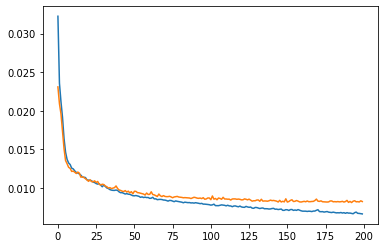

In [5]:
plt.plot(range(len(train_loss_epoch)), train_loss_epoch)
plt.plot(range(len(test_loss_epoch)), test_loss_epoch)

[0.25162527 0.13995165 0.54524754]


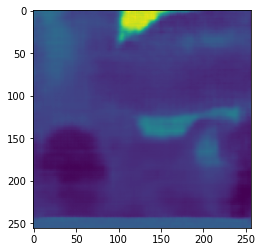

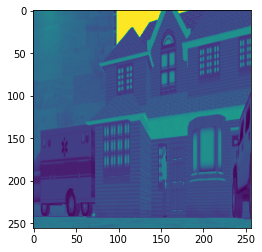

[0.78604767 0.53113278 0.55695054]


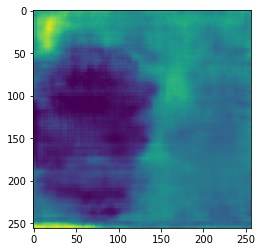

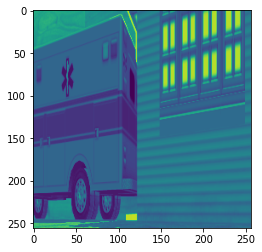

[0.76612769 0.96949237 0.16490688]


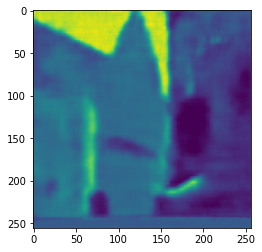

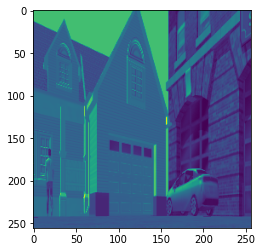

[0.51000167 0.57722764 0.98562707]


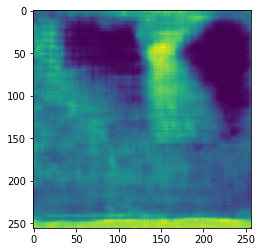

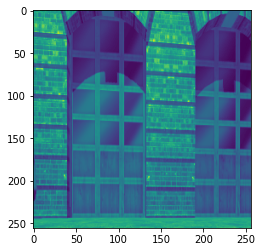

[0.45865978 0.12144703 0.93025424]


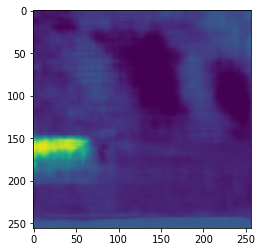

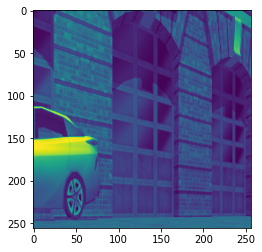

[0.87272879 0.57072601 0.87916321]


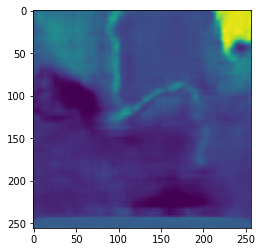

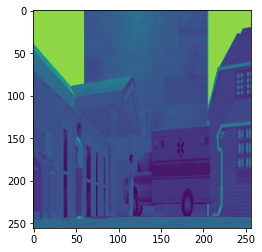

[0.5734289  0.8870551  0.86367685]


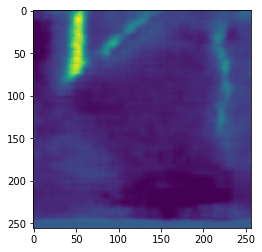

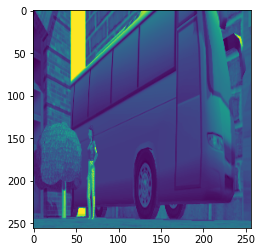

[0.11076846 0.76735851 0.88274696]


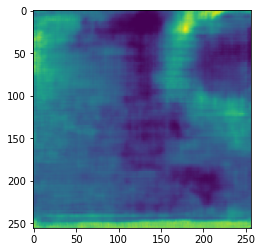

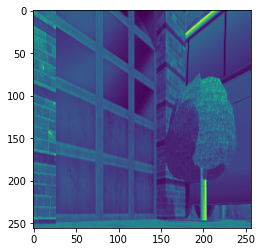

[0.51308551 0.66866717 0.94787165]


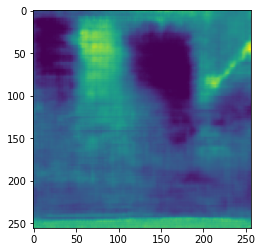

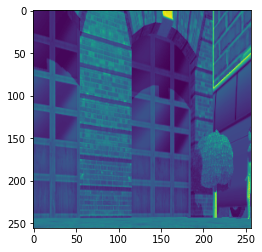

[0.85589265 0.7242644  0.56525697]


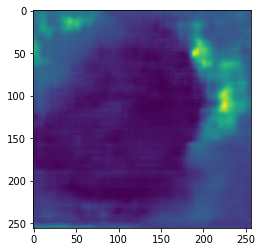

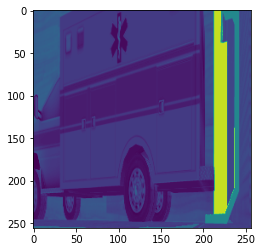

In [12]:
for i in random.sample(range(len(train_pose)), 10):
    print(train_pose[i])
    plt.imshow(net(torch.tensor(train_pose[i]).unsqueeze(0).unsqueeze(1).float().cuda()).cpu().detach().numpy().squeeze())
    plt.show()
    plt.imshow(train_img[i])
    plt.show()